# 1. Анализ текстов с использованием метода Word2vec

Word2vec - это еще один агоритм преобразования текстов в точки в векторном пространстве признаков. В его основе лежит нейронная сеть - автоэнкодер, который преобразует слово в вектор фиксированной длины. Особенность этого алгоритма заключается в том, что он учитывает семантику слов. Близкие по смыслу слова будут располагаться ближе друг к другу в векторном пространстве, а далекие - дальше. Если объем текстов достаточно большой, то с помощью модели word2vec мы можем определять синонимы и антонимы слов, и, благодаря этому, точность классификации текстов может увеличиться.

Сегодня будем пользоваться теми же наборами текстов, что и в прошлый раз. Прежде всего установим уже известные вам библиотеки для работы с текстовыми данными.


In [58]:
# !pip install pymorphy2 nltk
import nltk
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\79214\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\79214\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Сейчас мы готовы к проведению предобработки текста. Но для того, чтобы работать с моделью word2vec, нам еще понадобится установить библиотеку gensim, в которой описана эта модель.

In [59]:
# !pip install gensim

Для демонстрации возможностей этой библиотеки снова возьмем набор данных с текстами твитов, где сразу же переименуем класс -1 в 0. Вспомним, как выглядит наш датасет.

In [60]:
# from google.colab import drive
# import os
# # drive.mount('/content/drive/')
# drive.mount("/content/drive/", force_remount=True)

In [61]:
import pandas as pd

df = pd.read_excel('../data-samples/tweets_example.xlsx')
df.positive[df.positive==-1] = 0
df.loc[16:25]

C:\Users\79214\AppData\Local\Temp/ipykernel_18712/1438614194.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.positive[df.positive==-1] = 0


,id,date,name,text,positive,rep,rtv,fav,total_count,fol,friends,list_count
16,4.089069e+17,1.386326e+09,fantanshik,"RT @Abdullin_A_R: @LikhodedovaMary эхх, а в УГ...",1.0,0.0,1.0,0.0,2074.0,82.0,44.0,5.0
17,4.089069e+17,1.386326e+09,Tienn_En,"@marinaysol а, а то подумала, что у тебя там п...",1.0,0.0,0.0,0.0,6362.0,30.0,28.0,1.0
18,4.089069e+17,1.386326e+09,bstrd666,@xLesherx @4EU3 зря вы с этой ерундой шутите))...,1.0,0.0,0.0,0.0,13431.0,473.0,111.0,2.0
19,4.089069e+17,1.386326e+09,esken_h,@Moscow_advokat Очень главное спасибо for МЕ...,1.0,0.0,0.0,0.0,126795.0,581.0,86.0,10.0
20,4.089069e+17,1.386326e+09,Obrazcova98,"У нас есть прекрасная история, как сдохнуть за...",1.0,0.0,0.0,0.0,492.0,14.0,23.0,0.0
21,4.089068e+17,1.386326e+09,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,0.0,0.0,0.0,0.0,8064.0,111.0,94.0,2.0
22,4.089068e+17,1.386326e+09,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",0.0,0.0,0.0,0.0,26.0,42.0,39.0,0.0
23,4.089069e+17,1.386326e+09,4post21,@elina_4post как говорят обещаного три года жд...,0.0,0.0,0.0,0.0,718.0,49.0,249.0,0.0
24,4.089069e+17,1.386326e+09,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",0.0,0.0,0.0,0.0,10628.0,207.0,200.0,0.0
25,4.089069e+17,1.386326e+09,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",0.0,0.0,0.0,0.0,35.0,17.0,34.0,0.0


Так же, как и при использовании изученных раньше алгоритмов векторизации текста, нам нужно провести очистку данных, т.е. привести все слова текстов к одинаковому виду и форме. Напишем для этого функцию, чтобы можно было потом все эти действия вызывать одной командой.

In [62]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2


morph = pymorphy2.MorphAnalyzer()


def text_preprocessing(text):
    """Функция принимает строку и возвращает список слов в начальной форме"""
    text = text.lower()                                                         # приводим текст к нижнему регистру
    text = re.sub(r"[^А-Яа-я]", " ", text)                                      # удаляем все некириллические символы
    words = word_tokenize(text)                                                 # разбиваем тексты на списки слов
    words = [morph.parse(word)[0].normal_form for word in words]                # приводим слова к начальной форме
    words = [word for word in words if word not in stopwords.words("russian")]  # удаляем слова из стоп-листа
    return words

In [63]:
preprocessed_df = df[["text", "positive"]]
preprocessed_df.text = df.text.apply(text_preprocessing)
preprocessed_df[15:25]

C:\Users\79214\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,text,positive
15,"[смотреть, случайно, аспирантура, попасть, нау...",1.0
16,"[эхх, угата, контрольный, предупреждать, контр...",1.0
17,"[подумать, пробежечка]",1.0
18,"[зря, ерунда, шутить, история, наблюдать, режи...",1.0
19,"[очень, главное, спасибо, медведа, работать, к...",1.0
20,"[прекрасный, история, сдохнуть, неделя]",1.0
21,"[работа, полный, пиддес, каждый, закрытие, мес...",0.0
22,"[коллега, сидеть, рубиться, долбать, винд, мочь]",0.0
23,"[говорить, обещаной, год, ждать]",0.0
24,"[желать, хороший, пол, удачный, посадка, очень...",0.0


Обратите внимание, на этот раз мы не удаляем редкие слова, поскольку теперь текст характеризуется не частотностью тех или иных слов, а семантикой слов, входящих в данный текст.

Теперь обучим модель word2vec. Поскольку это не предиктивная модель, будем обучать ее на всём множестве текстов, чтобы получить векторное представление как можно большего количества слов. Подробно о параметрах модели можно почитать в официальной [документации](https://radimrehurek.com/gensim/models/word2vec.html).

In [64]:
from gensim.models import Word2Vec

w2v = Word2Vec(vector_size=300, min_count=1)  # создадим экземпляр модели word2vec. Здесь size - размер векторного пространства,
                                       # min_count - минимальное количество появлений слова в наборе данных, при котором
                                       # будем учитывать это слово в модели
w2v.build_vocab(preprocessed_df.text)  # обучим модель на нашем наборе текстов

Теперь посмотрим, какую информацию о словах мы можем получить из обученной модели. Например, для выбранного нами слова можем посмотреть список наиболее похожих на него слов с точки зрения модели.

In [65]:
w2v.wv.most_similar(positive="ерунда")  # этот метод возвращает список кортежей, где первый элемент - это слово,
                                        # а второй - степень схожести со словом "ерунда". Чем ближе это число к 1,
                                        # тем ближе по смыслу выведенное слово

[('новый', 0.19879138469696045),
 ('вообще', 0.19217327237129211),
 ('мальчик', 0.1701221913099289),
 ('рубиться', 0.14808665215969086),
 ('рада', 0.14677517116069794),
 ('обещаной', 0.12424545735120773),
 ('винд', 0.11481525748968124),
 ('россия', 0.11323855072259903),
 ('увидеть', 0.11053305119276047),
 ('деревня', 0.10091958194971085)]

Аналогично можем посмотреть наименее похожие слова:

In [66]:
w2v.wv.most_similar(negative=["ерунда"])  # аргумент negative говорит о том, что нужно искать наименее похожие слова.
                                          # В этом случае числа - это степень непохожести.
                                          # Чем ближе к 1, тем слово меньше похоже на "ерунду"

[('общество', 0.14702367782592773),
 ('страдать', 0.14572249352931976),
 ('самый', 0.1357945203781128),
 ('задумать', 0.13516543805599213),
 ('тп', 0.13276904821395874),
 ('зелёный', 0.127563938498497),
 ('полный', 0.11560172587633133),
 ('мск', 0.11394203454256058),
 ('шаблон', 0.1130000576376915),
 ('таки', 0.11047960817813873)]

Метод `most_similar` может помочь нам определить слова, которые наиболее похожи на один набор слов и наименее похожи на другой набор слов.

In [67]:
w2v.wv.most_similar(positive=["подняться", "угата"], negative=["погибать", "клоун"])

# на этот раз цифры - это некая общая метрика похожести на то, что мы просим

[('общество', 0.17890748381614685),
 ('гордый', 0.15167194604873657),
 ('долго', 0.14699722826480865),
 ('добрый', 0.13322556018829346),
 ('мочь', 0.1329142153263092),
 ('просто', 0.1327962577342987),
 ('ждать', 0.12339631468057632),
 ('твой', 0.1222352609038353),
 ('который', 0.10499396920204163),
 ('часть', 0.099699966609478)]

Еще можно посмотреть, насколько похожи два слова из выборки

In [68]:
w2v.wv.similarity("клоун", "работа")  # ответ может быть отрицательным - это будет означать, что
                                         # эта пара слов - больше антонимы, чем синонимы

0.0813069

Очевидно, что с теми словами, которых не было в обучающей выборке, модель работать не сможет:

In [69]:
w2v.wv.most_similar("сбербанк")

KeyError: "Key 'сбербанк' not present"

А теперь давайте посмотрим на график, какие слова как расположены друг относительно друга. По умолчанию модель word2vec отображает все слова в пространство размерности 300. Это означает, что каждое слово превращается в набор из 300 чисел. На мониторе такую размерность отобразить очень сложно, поэтому воспользуемся методом снижения размерности векторного пространства t-SNE. Сожмем наши вектора до размерности 2, чтобы их легко можно было отобразить на плоскости.

In [215]:
from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)


def reduce_dimensions(w2v_model):
    """Фукнция принимает модель word2vec и возвращает массив абсцисс,
    массив ординат и массив слов после снижения размерности"""
    tsne = TSNE(n_components=2, random_state=256)  # создадим экземпляр модели TSNE
    vectors = np.asarray(w2v_model.wv.vectors)     # возьмем из модели 300-мерный массив слов-векторов
    labels = np.asarray(w2v_model.wv.index_to_key)   # отдельно сохраним соответствие номера вектора и самого слова
    vectors = tsne.fit_transform(vectors)          # проведем преобразование каждого вектора в 2-мерный

    x = [v[0] for v in vectors]                    # запишем отдельно массив абсцисс и массив ординат
    y = [v[1] for v in vectors]
    return x, y, labels


def plot_w2v(w2v_model):
    """Функция строит график распределения слов по векторному пространству
    размерности 2 исходя из обученной модели word2vec"""
    x, y, labels = reduce_dimensions(w2v_model)                      # получим значения по осям и названия точек (исходные слова)
    plt.scatter(x, y)                                                # строим график с точками
    words_to_show_indices = np.random.randint(len(labels), size=100)  # выберем 25 случайных слов, которые отобразим на графике
    for i in words_to_show_indices:
        plt.annotate(labels[i], (x[i], y[i]))                        # для каждого из этих 25 слов отобразим текст на картинке


plot_w2v(w2v)                                                        # применим написанные функции к обученной модели

Кроме вышеперечисленных возможностей, можно обучить модель word2vec на предсказание следующих слов. Обучим ее и попробуем предсказать продолжение твита "Котёнка вчера носик разбила, плакала и расстраивалась :("

In [ ]:
w2v.train(preprocessed_df.text, total_examples=preprocessed_df.shape[0], epochs=10000)
w2v.predict_output_word(["вчера", "носик", "разбить"])

Вообще говоря, списки синонимов и антонимов у нас получились достаточно спорные. Причина этого - малая выборка слов, на которых обучалась модель. Внутри word2vec используется нейросеть-автоэнкодер, а таким моделям всегда нужно много данных для того, чтобы составить корректное отображение входных данных в векторное пространство. Чем больше слов в тексте, тем понятней, какие слова похожи по значению, а какие наоборот противоположны.

# Задание 1
1. Проведите предобработку текстов из файлов positive.csv, negative.csv. Нужно выполнить те же действия, что в предыдущем дне, но не удалять редко встречающиеся слова. Регулировать использование редких слов будем на уровне модели word2vec. Не забудьте удалить стоп-слова.
2. Будем исследовать то, как влияют на качество преобразования *размер целевого векторного пространства* и *использование редких слов*. Создайте несколько моделей word2vec, перебрав параметры:
  - размер результирующего пространства: [10, 300, 500] при фиксированной минимальной встречаемости слов = 10
  - минимальная встречаемость слов: [1, 10, 100] при фиксированном размере результирующего векторного пространства = 300

  Обучите их на всем пространстве текстов.

3. Отберите 5 случайных слов из выборки позитивных публикаций и 5 случайных слови из выборки негативных публикаций.
4. Для каждой из обученных моделей найдите по 15 синонимов и по 15 антонимов для каждого из слов из п.3. Опишите:
  - как влияет размер результирующего пространства на точность определения синонимов/антонимов моделью? почему?
  - как влияет минимальная встречаемость слов на точность определения синонимов/антонимов моделью? почему?
5. Постройте графики распределения слов в двумерном пространстве. Опишите, как влияют исследуемые параметры на кучность и расположение точек на графике. Почему?
6. Возьмите любой твит, обучите модель word2vec с параметрами по умолчанию и попробуйте предсказать продолжение твита. Также попробуйте предсказать продолжение случайной фразы. Сравните результаты, полученные после обучения моделей с разным количеством эпох обучения.

In [1]:
# код выполнения задания 1

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from gensim.models import Word2Vec
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
import nltk

from sklearn.manifold import TSNE
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)

In [2]:
positive_df = pd.read_csv('../datasets/positive.csv', sep=';', header=None)
positive_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
114906,411368729235054592,1386912922,diminlisenok,"Спала в родительском доме, на своей кровати......",1,0,0,0,1497,56,34,2
114907,411368729424187392,1386912922,qilepocagotu,RT @jebesilofyt: Эх... Мы немного решили сокра...,1,0,1,0,692,225,210,0
114908,411368796537257984,1386912938,DennyChooo,"Что происходит со мной, когда в эфире #proacti...",1,0,0,0,4905,448,193,13
114909,411368797447417856,1386912938,bedowabymir,"""Любимая,я подарю тебе эту звезду..."" Имя како...",1,0,0,0,989,254,251,0


In [3]:
negotiate_df = pd.read_csv('../datasets/negative.csv', sep=';', header=None)
negotiate_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906762813579264,1386325944,dugarchikbellko,на работе был полный пиддес :| и так каждое за...,-1,0,0,0,8064,111,94,2
1,408906818262687744,1386325957,nugemycejela,"Коллеги сидят рубятся в Urban terror, а я из-з...",-1,0,0,0,26,42,39,0
2,408906858515398656,1386325966,4post21,@elina_4post как говорят обещаного три года жд...,-1,0,0,0,718,49,249,0
3,408906914437685248,1386325980,Poliwake,"Желаю хорошего полёта и удачной посадки,я буду...",-1,0,0,0,10628,207,200,0
4,408906914723295232,1386325980,capyvixowe,"Обновил за каким-то лешим surf, теперь не рабо...",-1,0,0,0,35,17,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...
111918,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,-1,0,0,0,1138,32,46,0
111919,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,-1,0,0,0,4822,38,32,0
111920,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",-1,0,0,1,165,13,16,0
111921,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",-1,0,1,0,2516,187,265,0


In [4]:
df = pd.concat([positive_df, negotiate_df], ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,408906692374446080,1386325927,pleease_shut_up,"@first_timee хоть я и школота, но поверь, у на...",1,0,0,0,7569,62,61,0
1,408906692693221377,1386325927,alinakirpicheva,"Да, все-таки он немного похож на него. Но мой ...",1,0,0,0,11825,59,31,2
2,408906695083954177,1386325927,EvgeshaRe,RT @KatiaCheh: Ну ты идиотка) я испугалась за ...,1,0,1,0,1273,26,27,0
3,408906695356973056,1386325927,ikonnikova_21,"RT @digger2912: ""Кто то в углу сидит и погибае...",1,0,1,0,1549,19,17,0
4,408906761416867842,1386325943,JumpyAlex,@irina_dyshkant Вот что значит страшилка :D\nН...,1,0,0,0,597,16,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
226829,425138243257253888,1390195830,Yanch_96,Но не каждый хочет что то исправлять:( http://...,-1,0,0,0,1138,32,46,0
226830,425138339503943682,1390195853,tkit_on,скучаю так :-( только @taaannyaaa вправляет мо...,-1,0,0,0,4822,38,32,0
226831,425138437684215808,1390195876,ckooker1,"Вот и в школу, в говно это идти уже надо(",-1,0,0,1,165,13,16,0
226832,425138490452344832,1390195889,LisaBeroud,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",-1,0,1,0,2516,187,265,0


In [5]:
col=['id', 'date', 'name', 'text', 'positive', 'rep', 'rtv', 'fav',
       'total_count', 'fol', 'friends', 'list_count']

In [6]:
df.columns = col

In [7]:
df.loc[df['positive'] == -1, 'positive'] = 0

In [8]:
morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")
russian_stopwords.sort()

def delete_stopword(words):
    global russian_stopwords
    new_s = [word for word in words if word not in russian_stopwords]
    return new_s

In [9]:
df.text = df.text.str.lower()
df.text = df.text.str.replace(r"[^А-Яа-я]"," ")

C:\Users\79214\AppData\Local\Temp/ipykernel_19104/2388170711.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.text = df.text.str.replace(r"[^А-Яа-я]"," ")


In [10]:
df.text = list(map(word_tokenize, df.text))

# 7:41

In [11]:
%%time

morph = pymorphy2.MorphAnalyzer()

def lemmatization(words):
    global morph
    new_s = [morph.parse(word)[0].normal_form for word in words]
    return new_s

df.text = list(map(lemmatization, df.text))

Wall time: 17min 49s


In [12]:
%%time
df.text = list(map(delete_stopword, df.text))

Wall time: 8.25 s


In [13]:
df.text

0         [школотый, поверь, самый, общество, профилиров...
1         [всё, таки, немного, похожий, мальчик, всё, ра...
2                                     [идиотка, испугаться]
3         [угол, сидеть, погибать, голод, ещ, порция, вз...
4         [значит, страшилка, блин, посмотреть, всё, час...
                                ...                        
226829                         [каждый, хотеть, исправлять]
226830      [скучать, вправлять, мозг, всё, равно, скучать]
226831                            [школа, говно, это, идти]
226832                           [тауриэль, грусть, обнять]
226833    [такси, везти, работа, раздумывать, приплатить...
Name: text, Length: 226834, dtype: object

In [14]:
# обучим модель на нашем наборе текстов
# первое тестовое обучение


w2v = Word2Vec(vector_size=300, min_count=10)
w2v.build_vocab(df.text)

In [15]:
# на что похожа ерунда

w2v.wv.most_similar(positive="ерунда", topn=15)

[('дополнение', 0.23196321725845337),
 ('пёсик', 0.22963543236255646),
 ('связь', 0.2134360820055008),
 ('глядеть', 0.2038142830133438),
 ('фонарик', 0.2023555487394333),
 ('сюжет', 0.1887308657169342),
 ('номинировать', 0.1884201616048813),
 ('показуха', 0.18724952638149261),
 ('дооолго', 0.1866271048784256),
 ('пострадать', 0.18382304906845093),
 ('работаться', 0.18114586174488068),
 ('въезд', 0.17907831072807312),
 ('висеть', 0.17871317267417908),
 ('видимый', 0.1773434281349182),
 ('фанат', 0.17360511422157288)]

In [21]:
# Подготавливаем слова из позитивной выборки и негативной

from nltk.probability import FreqDist

def to_str(s):
    new_s = ' '.join(j for j in s)
    return new_s

def my_fdist(tvit_text):
    text_tokens = word_tokenize(' '.join(j for j in list(map(to_str, tvit_text))))
    text = nltk.Text(text_tokens)
    fdist = FreqDist(text)
    return fdist

fdist_p = my_fdist(df.text[df.positive == 1])
fdist_n = my_fdist(df.text[df.positive == 0])
words_p = list(filter(lambda k: fdist_p[k] >= 100, fdist_p))
words_n = list(filter(lambda k: fdist_n[k] >= 100, fdist_n))

In [240]:
# Экскременты

# w2v = Word2Vec(vector_size=300, min_count=1)
# w2v.build_vocab(df.text)
# w2v.wv.most_similar(positive='крафтовый', topn=15)
# test_words_p = list(filter(lambda k: fdist[k] >= 1, fdist_p))
# 'крафтовый' in test_words_p

[('навчис', 0.2541864216327667),
 ('лохонуться', 0.24995428323745728),
 ('задирать', 0.2311902642250061),
 ('забава', 0.22628465294837952),
 ('повесить', 0.2184675633907318),
 ('катюююююнуть', 0.21786300837993622),
 ('неандерталец', 0.21265701949596405),
 ('анкедот', 0.21134230494499207),
 ('блюстить', 0.20815035700798035),
 ('меять', 0.20774339139461517),
 ('социо', 0.2069164514541626),
 ('протрахаться', 0.20580889284610748),
 ('нук', 0.20416566729545593),
 ('шама', 0.2037370502948761),
 ('айпишник', 0.20275938510894775)]

In [17]:
def reduce_dimensions(w2v_model):
    """Фукнция принимает модель word2vec и возвращает массив абсцисс,
    массив ординат и массив слов после снижения размерности"""
    tsne = TSNE(n_components=2, random_state=256)
    vectors = np.asarray(w2v_model.wv.vectors)
    vectors = tsne.fit_transform(vectors)

    x = [v[0] for v in vectors]
    y = [v[1] for v in vectors]
    return x, y


def plot_w2v(w2v_model):
    """Функция строит график распределения слов по векторному пространству
    размерности 2 исходя из обученной модели word2vec"""
    x, y = reduce_dimensions(w2v_model)
    plt.scatter(x, y)
    plt.show()

FreqDist({'это': 11154, 'всё': 9098, 'хотеть': 8113, 'мочь': 5470, 'день': 5226, 'весь': 4918, 'ещё': 4495, 'сегодня': 4366, 'очень': 4053, 'год': 3776, ...})

In [22]:
# функция для анализа гипер параметров
from IPython.display import display

def synonyms_and_antonyms(words):
    np.random.seed(21)
    my_dict = {}
    for word in np.random.choice(words, size=5):
        my_dict['синонимы ' + word] = [x[0] for x in w2v.wv.most_similar(positive=word, topn=15)]
        my_dict['антонимы ' + word] = [x[0] for x in w2v.wv.most_similar(negative=word, topn=15)]
        
    return pd.DataFrame(my_dict)


def my_w2v(text, vector_size=300, min_count=10):
    global words_p, words_n
    
    w2v = Word2Vec(vector_size=vector_size, min_count=min_count)
    w2v.build_vocab(text)
    
    print("\n\n--- 5 случайных слов из выборки позитивных публикаций ---")
    display(synonyms_and_antonyms(words_p))
        
    print("\n\n--- 5 случайных слов из выборки негативных публикаций ---")
    display(synonyms_and_antonyms(words_n))
    
    plot_w2v(w2v)

def test_param_w2v(text, vector_size=[10, 300, 500], min_count=[1, 10, 100]):
    print('------------СТАРТ ТЕСТА-------------\n')
    for x in min_count:
        print(f'\n\ntest parameters vector_size=300 min_count={x}\n')
        my_w2v(text, min_count=x)
        
    for x in vector_size:
        print(f'\n\ntest parameters vector_size={x} min_count=10\n')
        my_w2v(text, vector_size=x)


------------СТАРТ ТЕСТА-------------



test parameters vector_size=300 min_count=1



--- 5 случайных слов из выборки позитивных публикаций ---


,синонимы возраст,антонимы возраст,синонимы поздний,антонимы поздний,синонимы ахи,антонимы ахи,синонимы пожалуйста,антонимы пожалуйста,синонимы лс,антонимы лс
0,цымбаларь,касса,незнакомка,завод,авторизация,ухта,июль,зачётный,позорище,снег
1,фанючка,й,туго,подсознание,вчерашний,шерстяной,индастриал,килограмм,вторник,привлечь
2,редкий,впасть,срок,параллельно,достоевский,нехуй,сирена,шалить,яяя,лимит
3,храниться,истерика,человеческий,инст,колыбельный,грег,хтмл,мужчина,котэ,согласно
4,гитара,обжечь,заслужить,магистратура,сурков,лока,менеджер,закончиться,хурдать,сера
5,благо,хотяб,различный,локомотив,усиленно,академия,рингтон,простыня,сраный,позорить
6,мда,головня,умный,рис,сера,телец,дабы,предстоящий,уезжать,офлайн
7,травмпункт,знакомство,представление,пята,сборка,сладость,текущий,уха,египет,марк
8,размер,претендовать,старуха,срочно,проворонить,вайн,уколоть,злой,поликлиника,упираться
9,неудачный,завидовать,аха,ванька,шт,способный,рх,оставлять,грузиться,ноут




--- 5 случайных слов из выборки негативных публикаций ---


,синонимы обед,антонимы обед,синонимы мда,антонимы мда,синонимы плохо,антонимы плохо,синонимы родный,антонимы родный,синонимы сутки,антонимы сутки
0,благодарность,ую,молодец,уволиться,мать,обложка,гигабайт,граф,корректор,хард
1,ву,республика,рифма,добежать,поторопиться,средний,богатый,прийти,сэкономить,папин
2,капёс,побегать,дневник,юу,обогреватель,частенько,отмазываться,сглазить,сглазить,лекарство
3,выдать,сговориться,ленивый,крестный,йл,аудитория,смотреть,ооий,спартак,анси
4,разваливаться,символичный,холл,коньковый,сопеть,ира,анестезия,сознание,рг,лааадно
5,диктант,городской,жечь,затея,окея,работать,полагать,ебашить,аттестат,толк
6,чуточку,инф,кислый,кусаться,посылочка,помимо,азаров,мск,олежка,головной
7,афигеть,гродно,вл,снегурочка,бешенство,бляблябль,детка,суперский,голодать,забыть
8,качалка,миленько,возраст,слюни,шантажировать,хто,сдать,экология,кино,арх
9,закидывать,джобс,завернуть,скользко,разучиться,оценка,алексей,повеситься,интуиция,разрешиться


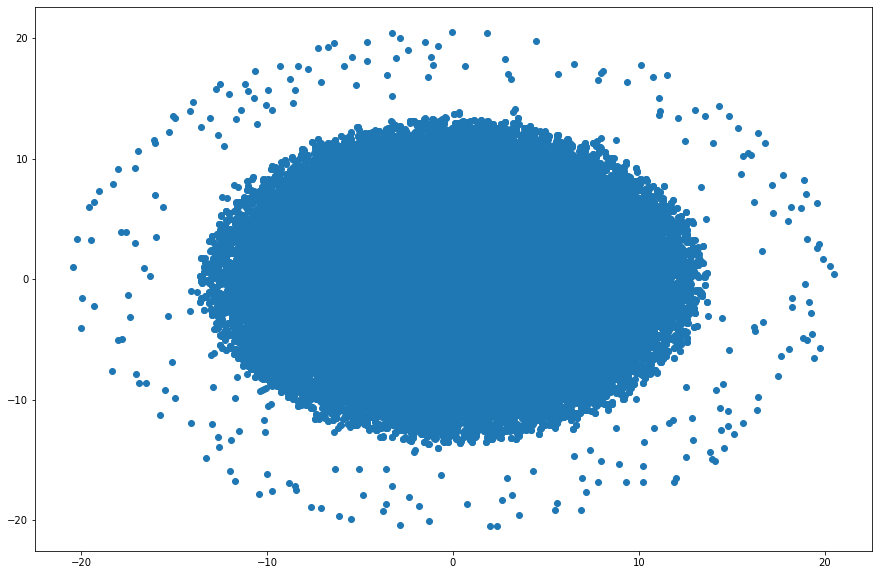



test parameters vector_size=300 min_count=10



--- 5 случайных слов из выборки позитивных публикаций ---


,синонимы возраст,антонимы возраст,синонимы поздний,антонимы поздний,синонимы ахи,антонимы ахи,синонимы пожалуйста,антонимы пожалуйста,синонимы лс,антонимы лс
0,цымбаларь,касса,незнакомка,завод,авторизация,ухта,июль,зачётный,позорище,снег
1,фанючка,й,туго,подсознание,вчерашний,шерстяной,индастриал,килограмм,вторник,привлечь
2,редкий,впасть,срок,параллельно,достоевский,нехуй,сирена,шалить,яяя,лимит
3,храниться,истерика,человеческий,инст,колыбельный,грег,хтмл,мужчина,котэ,согласно
4,гитара,обжечь,заслужить,магистратура,сурков,лока,менеджер,закончиться,хурдать,сера
5,благо,хотяб,различный,локомотив,усиленно,академия,рингтон,простыня,сраный,позорить
6,мда,головня,умный,рис,сера,телец,дабы,предстоящий,уезжать,офлайн
7,травмпункт,знакомство,представление,пята,сборка,сладость,текущий,уха,египет,марк
8,размер,претендовать,старуха,срочно,проворонить,вайн,уколоть,злой,поликлиника,упираться
9,неудачный,завидовать,аха,ванька,шт,способный,рх,оставлять,грузиться,ноут




--- 5 случайных слов из выборки негативных публикаций ---


,синонимы обед,антонимы обед,синонимы мда,антонимы мда,синонимы плохо,антонимы плохо,синонимы родный,антонимы родный,синонимы сутки,антонимы сутки
0,благодарность,ую,молодец,уволиться,мать,обложка,гигабайт,граф,корректор,хард
1,ву,республика,рифма,добежать,поторопиться,средний,богатый,прийти,сэкономить,папин
2,капёс,побегать,дневник,юу,обогреватель,частенько,отмазываться,сглазить,сглазить,лекарство
3,выдать,сговориться,ленивый,крестный,йл,аудитория,смотреть,ооий,спартак,анси
4,разваливаться,символичный,холл,коньковый,сопеть,ира,анестезия,сознание,рг,лааадно
5,диктант,городской,жечь,затея,окея,работать,полагать,ебашить,аттестат,толк
6,чуточку,инф,кислый,кусаться,посылочка,помимо,азаров,мск,олежка,головной
7,афигеть,гродно,вл,снегурочка,бешенство,бляблябль,детка,суперский,голодать,забыть
8,качалка,миленько,возраст,слюни,шантажировать,хто,сдать,экология,кино,арх
9,закидывать,джобс,завернуть,скользко,разучиться,оценка,алексей,повеситься,интуиция,разрешиться


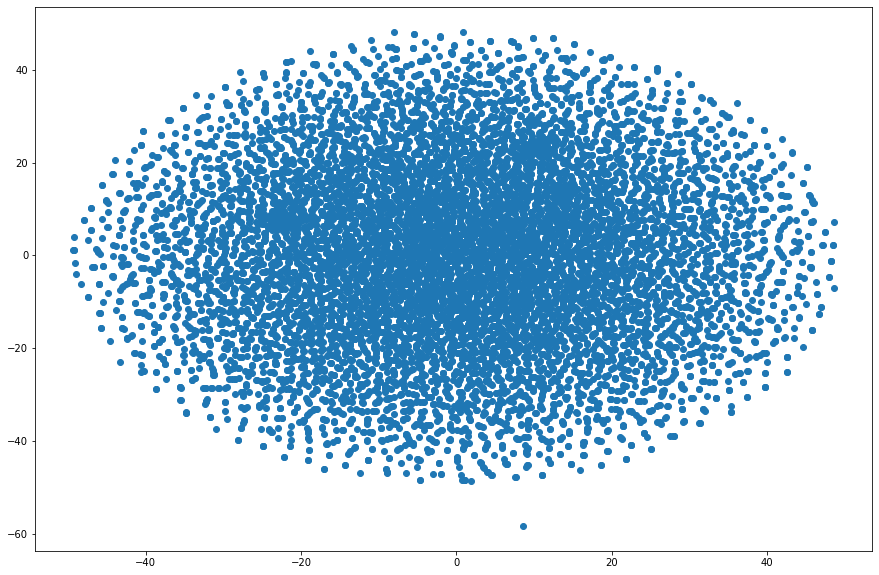



test parameters vector_size=300 min_count=100



--- 5 случайных слов из выборки позитивных публикаций ---


,синонимы возраст,антонимы возраст,синонимы поздний,антонимы поздний,синонимы ахи,антонимы ахи,синонимы пожалуйста,антонимы пожалуйста,синонимы лс,антонимы лс
0,цымбаларь,касса,незнакомка,завод,авторизация,ухта,июль,зачётный,позорище,снег
1,фанючка,й,туго,подсознание,вчерашний,шерстяной,индастриал,килограмм,вторник,привлечь
2,редкий,впасть,срок,параллельно,достоевский,нехуй,сирена,шалить,яяя,лимит
3,храниться,истерика,человеческий,инст,колыбельный,грег,хтмл,мужчина,котэ,согласно
4,гитара,обжечь,заслужить,магистратура,сурков,лока,менеджер,закончиться,хурдать,сера
5,благо,хотяб,различный,локомотив,усиленно,академия,рингтон,простыня,сраный,позорить
6,мда,головня,умный,рис,сера,телец,дабы,предстоящий,уезжать,офлайн
7,травмпункт,знакомство,представление,пята,сборка,сладость,текущий,уха,египет,марк
8,размер,претендовать,старуха,срочно,проворонить,вайн,уколоть,злой,поликлиника,упираться
9,неудачный,завидовать,аха,ванька,шт,способный,рх,оставлять,грузиться,ноут




--- 5 случайных слов из выборки негативных публикаций ---


,синонимы обед,антонимы обед,синонимы мда,антонимы мда,синонимы плохо,антонимы плохо,синонимы родный,антонимы родный,синонимы сутки,антонимы сутки
0,благодарность,ую,молодец,уволиться,мать,обложка,гигабайт,граф,корректор,хард
1,ву,республика,рифма,добежать,поторопиться,средний,богатый,прийти,сэкономить,папин
2,капёс,побегать,дневник,юу,обогреватель,частенько,отмазываться,сглазить,сглазить,лекарство
3,выдать,сговориться,ленивый,крестный,йл,аудитория,смотреть,ооий,спартак,анси
4,разваливаться,символичный,холл,коньковый,сопеть,ира,анестезия,сознание,рг,лааадно
5,диктант,городской,жечь,затея,окея,работать,полагать,ебашить,аттестат,толк
6,чуточку,инф,кислый,кусаться,посылочка,помимо,азаров,мск,олежка,головной
7,афигеть,гродно,вл,снегурочка,бешенство,бляблябль,детка,суперский,голодать,забыть
8,качалка,миленько,возраст,слюни,шантажировать,хто,сдать,экология,кино,арх
9,закидывать,джобс,завернуть,скользко,разучиться,оценка,алексей,повеситься,интуиция,разрешиться


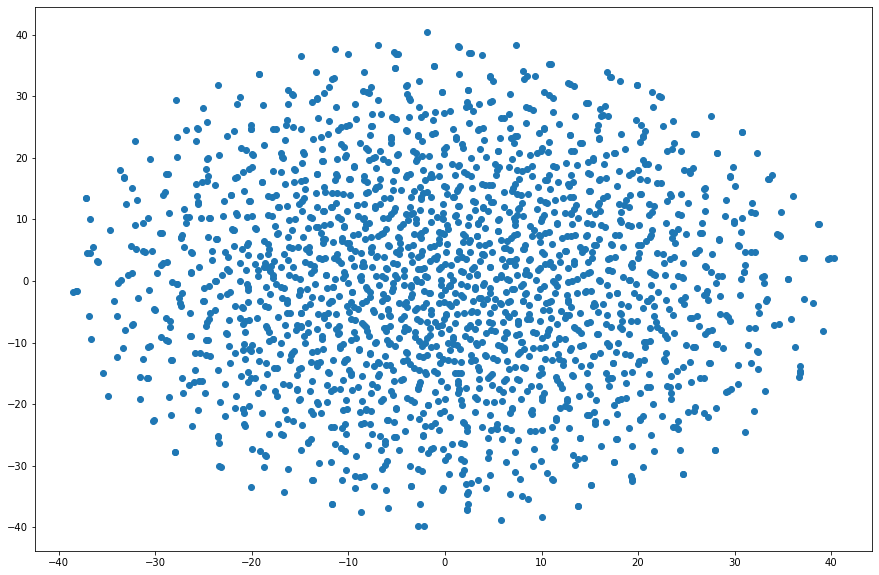



test parameters vector_size=10 min_count=10



--- 5 случайных слов из выборки позитивных публикаций ---


,синонимы возраст,антонимы возраст,синонимы поздний,антонимы поздний,синонимы ахи,антонимы ахи,синонимы пожалуйста,антонимы пожалуйста,синонимы лс,антонимы лс
0,цымбаларь,касса,незнакомка,завод,авторизация,ухта,июль,зачётный,позорище,снег
1,фанючка,й,туго,подсознание,вчерашний,шерстяной,индастриал,килограмм,вторник,привлечь
2,редкий,впасть,срок,параллельно,достоевский,нехуй,сирена,шалить,яяя,лимит
3,храниться,истерика,человеческий,инст,колыбельный,грег,хтмл,мужчина,котэ,согласно
4,гитара,обжечь,заслужить,магистратура,сурков,лока,менеджер,закончиться,хурдать,сера
5,благо,хотяб,различный,локомотив,усиленно,академия,рингтон,простыня,сраный,позорить
6,мда,головня,умный,рис,сера,телец,дабы,предстоящий,уезжать,офлайн
7,травмпункт,знакомство,представление,пята,сборка,сладость,текущий,уха,египет,марк
8,размер,претендовать,старуха,срочно,проворонить,вайн,уколоть,злой,поликлиника,упираться
9,неудачный,завидовать,аха,ванька,шт,способный,рх,оставлять,грузиться,ноут




--- 5 случайных слов из выборки негативных публикаций ---


,синонимы обед,антонимы обед,синонимы мда,антонимы мда,синонимы плохо,антонимы плохо,синонимы родный,антонимы родный,синонимы сутки,антонимы сутки
0,благодарность,ую,молодец,уволиться,мать,обложка,гигабайт,граф,корректор,хард
1,ву,республика,рифма,добежать,поторопиться,средний,богатый,прийти,сэкономить,папин
2,капёс,побегать,дневник,юу,обогреватель,частенько,отмазываться,сглазить,сглазить,лекарство
3,выдать,сговориться,ленивый,крестный,йл,аудитория,смотреть,ооий,спартак,анси
4,разваливаться,символичный,холл,коньковый,сопеть,ира,анестезия,сознание,рг,лааадно
5,диктант,городской,жечь,затея,окея,работать,полагать,ебашить,аттестат,толк
6,чуточку,инф,кислый,кусаться,посылочка,помимо,азаров,мск,олежка,головной
7,афигеть,гродно,вл,снегурочка,бешенство,бляблябль,детка,суперский,голодать,забыть
8,качалка,миленько,возраст,слюни,шантажировать,хто,сдать,экология,кино,арх
9,закидывать,джобс,завернуть,скользко,разучиться,оценка,алексей,повеситься,интуиция,разрешиться


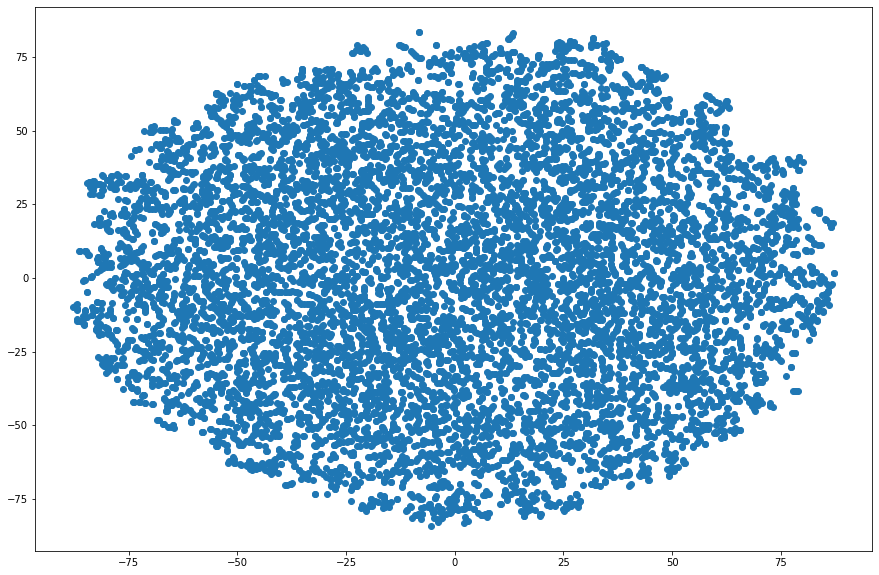



test parameters vector_size=300 min_count=10



--- 5 случайных слов из выборки позитивных публикаций ---


,синонимы возраст,антонимы возраст,синонимы поздний,антонимы поздний,синонимы ахи,антонимы ахи,синонимы пожалуйста,антонимы пожалуйста,синонимы лс,антонимы лс
0,цымбаларь,касса,незнакомка,завод,авторизация,ухта,июль,зачётный,позорище,снег
1,фанючка,й,туго,подсознание,вчерашний,шерстяной,индастриал,килограмм,вторник,привлечь
2,редкий,впасть,срок,параллельно,достоевский,нехуй,сирена,шалить,яяя,лимит
3,храниться,истерика,человеческий,инст,колыбельный,грег,хтмл,мужчина,котэ,согласно
4,гитара,обжечь,заслужить,магистратура,сурков,лока,менеджер,закончиться,хурдать,сера
5,благо,хотяб,различный,локомотив,усиленно,академия,рингтон,простыня,сраный,позорить
6,мда,головня,умный,рис,сера,телец,дабы,предстоящий,уезжать,офлайн
7,травмпункт,знакомство,представление,пята,сборка,сладость,текущий,уха,египет,марк
8,размер,претендовать,старуха,срочно,проворонить,вайн,уколоть,злой,поликлиника,упираться
9,неудачный,завидовать,аха,ванька,шт,способный,рх,оставлять,грузиться,ноут




--- 5 случайных слов из выборки негативных публикаций ---


,синонимы обед,антонимы обед,синонимы мда,антонимы мда,синонимы плохо,антонимы плохо,синонимы родный,антонимы родный,синонимы сутки,антонимы сутки
0,благодарность,ую,молодец,уволиться,мать,обложка,гигабайт,граф,корректор,хард
1,ву,республика,рифма,добежать,поторопиться,средний,богатый,прийти,сэкономить,папин
2,капёс,побегать,дневник,юу,обогреватель,частенько,отмазываться,сглазить,сглазить,лекарство
3,выдать,сговориться,ленивый,крестный,йл,аудитория,смотреть,ооий,спартак,анси
4,разваливаться,символичный,холл,коньковый,сопеть,ира,анестезия,сознание,рг,лааадно
5,диктант,городской,жечь,затея,окея,работать,полагать,ебашить,аттестат,толк
6,чуточку,инф,кислый,кусаться,посылочка,помимо,азаров,мск,олежка,головной
7,афигеть,гродно,вл,снегурочка,бешенство,бляблябль,детка,суперский,голодать,забыть
8,качалка,миленько,возраст,слюни,шантажировать,хто,сдать,экология,кино,арх
9,закидывать,джобс,завернуть,скользко,разучиться,оценка,алексей,повеситься,интуиция,разрешиться


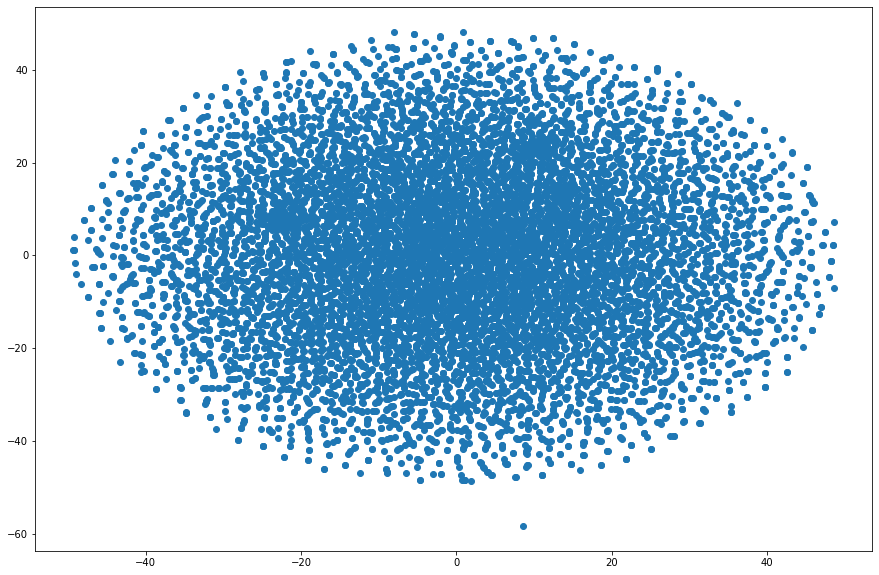



test parameters vector_size=500 min_count=10



--- 5 случайных слов из выборки позитивных публикаций ---


,синонимы возраст,антонимы возраст,синонимы поздний,антонимы поздний,синонимы ахи,антонимы ахи,синонимы пожалуйста,антонимы пожалуйста,синонимы лс,антонимы лс
0,цымбаларь,касса,незнакомка,завод,авторизация,ухта,июль,зачётный,позорище,снег
1,фанючка,й,туго,подсознание,вчерашний,шерстяной,индастриал,килограмм,вторник,привлечь
2,редкий,впасть,срок,параллельно,достоевский,нехуй,сирена,шалить,яяя,лимит
3,храниться,истерика,человеческий,инст,колыбельный,грег,хтмл,мужчина,котэ,согласно
4,гитара,обжечь,заслужить,магистратура,сурков,лока,менеджер,закончиться,хурдать,сера
5,благо,хотяб,различный,локомотив,усиленно,академия,рингтон,простыня,сраный,позорить
6,мда,головня,умный,рис,сера,телец,дабы,предстоящий,уезжать,офлайн
7,травмпункт,знакомство,представление,пята,сборка,сладость,текущий,уха,египет,марк
8,размер,претендовать,старуха,срочно,проворонить,вайн,уколоть,злой,поликлиника,упираться
9,неудачный,завидовать,аха,ванька,шт,способный,рх,оставлять,грузиться,ноут




--- 5 случайных слов из выборки негативных публикаций ---


,синонимы обед,антонимы обед,синонимы мда,антонимы мда,синонимы плохо,антонимы плохо,синонимы родный,антонимы родный,синонимы сутки,антонимы сутки
0,благодарность,ую,молодец,уволиться,мать,обложка,гигабайт,граф,корректор,хард
1,ву,республика,рифма,добежать,поторопиться,средний,богатый,прийти,сэкономить,папин
2,капёс,побегать,дневник,юу,обогреватель,частенько,отмазываться,сглазить,сглазить,лекарство
3,выдать,сговориться,ленивый,крестный,йл,аудитория,смотреть,ооий,спартак,анси
4,разваливаться,символичный,холл,коньковый,сопеть,ира,анестезия,сознание,рг,лааадно
5,диктант,городской,жечь,затея,окея,работать,полагать,ебашить,аттестат,толк
6,чуточку,инф,кислый,кусаться,посылочка,помимо,азаров,мск,олежка,головной
7,афигеть,гродно,вл,снегурочка,бешенство,бляблябль,детка,суперский,голодать,забыть
8,качалка,миленько,возраст,слюни,шантажировать,хто,сдать,экология,кино,арх
9,закидывать,джобс,завернуть,скользко,разучиться,оценка,алексей,повеситься,интуиция,разрешиться


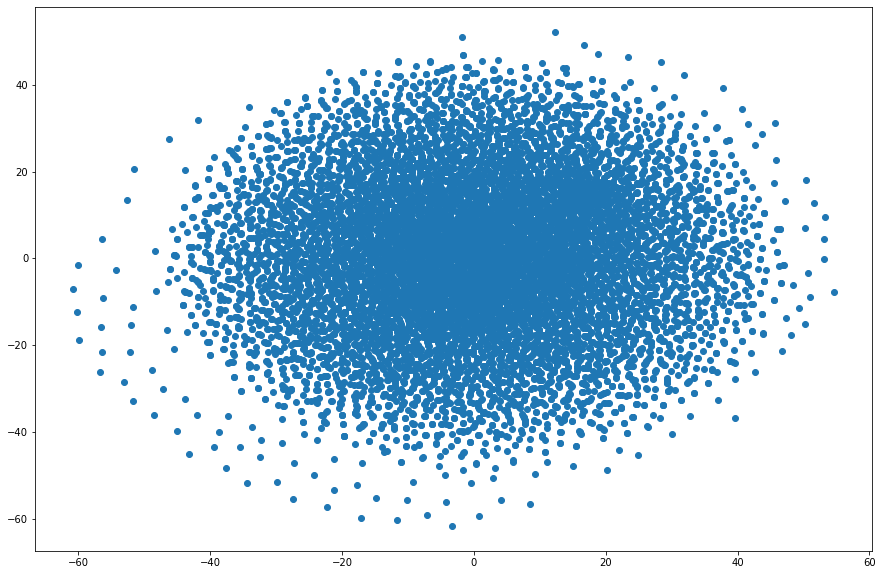

In [23]:
test_param_w2v(df.text)

---

## Выводы:
Влияние размеров результирующего пространства на точность определения синонимов/антонимов моделью:

        - неразличимое (Возможно из-за малого количества слов)
        - графики распределения слов в двумерном пространстве сужается и граничные значения по модулю становятся меньше так как возможное отклонение векторов по количеству пространств позволяет задать более короткими те самые вектора.

Влияние минимальной встречаемости слов на точность определения синонимов/антонимов модель:

        - с уменьшением параметра встречаемости слов распределение синонимов и антонимов не меняется.
        - на графике распределения слов в двумерном пространстве возрастает плотность распределения векторов. При значениях параметра "1" большая часть векторов концентрируется в пределах значений [-15; 15] по оси абсцисс и ординат с редкими выбросами до значений [-25; 25] видимо это происходит из-за большей семантической схожести слов.



In [27]:
w2v = Word2Vec()
w2v.build_vocab(df.text)

In [31]:
# Обучение модели с разным количеством эпох обучения


for n in range(1, 100, 10):
    print(f'Количество эпох - {n}')
    w2v.train(df.text, total_examples=df.shape[0], epochs=n)
    print('Фраза 1 ["вчера", "носик", "разбить"]')
    display(w2v.predict_output_word(["вчера", "носик", "разбить"]))
    print('Фраза 2 ["мужчина", "шалить"]')
    display(w2v.predict_output_word(["мужчина", "шалить"]))
    



Количество эпох - 1
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.8397402),
 ('вылезти', 0.055183508),
 ('ипать', 0.01575094),
 ('носик', 0.01223384),
 ('удаль', 0.012153034),
 ('коричневый', 0.008062166),
 ('ручка', 0.007823276),
 ('разбить', 0.0061105913),
 ('боиться', 0.004810337),
 ('обнаружить', 0.0038198533)]

Фраза 2 ["мужчина", "шалить"]


[('мстить', 0.17626691),
 ('пейзаж', 0.09534894),
 ('проспект', 0.09097062),
 ('кричать', 0.0664621),
 ('православный', 0.059012413),
 ('экипаж', 0.053419843),
 ('территория', 0.049640384),
 ('немножечко', 0.035665706),
 ('охуеть', 0.034178723),
 ('мимимишный', 0.022677358)]

Количество эпох - 11
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.8551525),
 ('носик', 0.03270587),
 ('ипать', 0.030207597),
 ('вылезти', 0.023500519),
 ('поправлять', 0.021373523),
 ('выбить', 0.004035446),
 ('удаль', 0.0037830847),
 ('расчесать', 0.0025715334),
 ('вешать', 0.0023171252),
 ('рамочка', 0.0020505541)]

Фраза 2 ["мужчина", "шалить"]


[('проспект', 0.14869215),
 ('мстить', 0.12109193),
 ('пожилой', 0.10153354),
 ('мимимишный', 0.0954297),
 ('мужичок', 0.057049308),
 ('экипаж', 0.034741893),
 ('немножечко', 0.032200877),
 ('обсуждение', 0.023588296),
 ('драма', 0.02014017),
 ('нервишки', 0.017756052)]

Количество эпох - 21
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.5362749),
 ('поправлять', 0.18775284),
 ('выбить', 0.04102446),
 ('ипать', 0.037676044),
 ('боиться', 0.025760693),
 ('носик', 0.021243151),
 ('угораздить', 0.01921456),
 ('вылезти', 0.014480334),
 ('обнаружить', 0.012413794),
 ('рамочка', 0.012020811)]

Фраза 2 ["мужчина", "шалить"]


[('кричать', 0.12811208),
 ('страстный', 0.1114456),
 ('мужичок', 0.06635215),
 ('экипаж', 0.043382954),
 ('обсуждение', 0.04173944),
 ('пожилой', 0.03669251),
 ('немножечко', 0.033222094),
 ('охуеть', 0.031389352),
 ('нтв', 0.028302664),
 ('проспект', 0.028008325)]

Количество эпох - 31
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.66632825),
 ('поправлять', 0.11635248),
 ('носик', 0.11481185),
 ('расчесать', 0.022585565),
 ('боиться', 0.013336329),
 ('визжать', 0.007807198),
 ('вешать', 0.0028550802),
 ('выбить', 0.002699794),
 ('бедненький', 0.002686627),
 ('запалить', 0.0024286262)]

Фраза 2 ["мужчина", "шалить"]


[('страстный', 0.35096085),
 ('обсуждение', 0.090064),
 ('проспект', 0.08597296),
 ('мстить', 0.08324238),
 ('нтв', 0.047853526),
 ('копыто', 0.026759867),
 ('экипаж', 0.02106656),
 ('драма', 0.017729308),
 ('чаепитие', 0.016113183),
 ('гэри', 0.013665543)]

Количество эпох - 41
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.68641996),
 ('боиться', 0.08061594),
 ('носик', 0.040258624),
 ('поправлять', 0.037309647),
 ('расчесать', 0.032990113),
 ('разбить', 0.009727946),
 ('рамочка', 0.009272022),
 ('визжать', 0.009212074),
 ('запалить', 0.008312916),
 ('обнаружить', 0.007198893)]

Фраза 2 ["мужчина", "шалить"]


[('страстный', 0.5190337),
 ('проспект', 0.22035047),
 ('лидия', 0.047081158),
 ('мужичок', 0.029492743),
 ('охуеть', 0.021272121),
 ('обсуждение', 0.012165171),
 ('дурд', 0.009908142),
 ('нтв', 0.0074197124),
 ('нервишки', 0.005872861),
 ('кричать', 0.005094254)]

Количество эпох - 51
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.32583377),
 ('носик', 0.18088605),
 ('боиться', 0.054622777),
 ('разбить', 0.047416735),
 ('угораздить', 0.03828273),
 ('выбить', 0.031604376),
 ('поправлять', 0.030808672),
 ('коричневый', 0.026658399),
 ('обломать', 0.013070916),
 ('обнаружить', 0.010865864)]

Фраза 2 ["мужчина", "шалить"]


[('проспект', 0.23011002),
 ('мужичок', 0.22714412),
 ('страстный', 0.16077894),
 ('недавний', 0.0361368),
 ('божеий', 0.023402112),
 ('лидия', 0.017498795),
 ('обсуждение', 0.016020337),
 ('нервишки', 0.0131143),
 ('кричать', 0.012475668),
 ('охуеть', 0.012250299)]

Количество эпох - 61
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.41861644),
 ('разбить', 0.049896266),
 ('вешать', 0.03952542),
 ('поправлять', 0.032811925),
 ('анька', 0.027589953),
 ('коричневый', 0.024160644),
 ('боиться', 0.02224414),
 ('обнаружить', 0.02062173),
 ('бедненький', 0.017972276),
 ('ипать', 0.013347166)]

Фраза 2 ["мужчина", "шалить"]


[('палатка', 0.20390189),
 ('страстный', 0.15133695),
 ('проспект', 0.1065144),
 ('нтв', 0.06501601),
 ('кричать', 0.053022835),
 ('охуеть', 0.040588006),
 ('божеий', 0.024719926),
 ('мужичок', 0.024655052),
 ('ровный', 0.01656725),
 ('набросок', 0.014228761)]

Количество эпох - 71
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.55652934),
 ('носик', 0.22949177),
 ('боиться', 0.01577931),
 ('бедненький', 0.014673611),
 ('угораздить', 0.010945442),
 ('расчесать', 0.009744405),
 ('поправлять', 0.009580257),
 ('вешать', 0.007304495),
 ('разбить', 0.007177413),
 ('ипать', 0.006963128)]

Фраза 2 ["мужчина", "шалить"]


[('проспект', 0.33073068),
 ('охуеть', 0.08988661),
 ('палатка', 0.083485626),
 ('страстный', 0.05281038),
 ('кран', 0.03348011),
 ('сумуя', 0.031091513),
 ('территория', 0.028718993),
 ('неожиданность', 0.027546894),
 ('нервишки', 0.019288506),
 ('мужичок', 0.01911788)]

Количество эпох - 81
Фраза 1 ["вчера", "носик", "разбить"]


[('носик', 0.24687341),
 ('угораздить', 0.14441296),
 ('боиться', 0.102868386),
 ('ушко', 0.08622939),
 ('разбить', 0.04309603),
 ('секундный', 0.021571578),
 ('обнаружить', 0.0197624),
 ('визжать', 0.018091638),
 ('расчесать', 0.018055934),
 ('поправлять', 0.013572003)]

Фраза 2 ["мужчина", "шалить"]


[('проспект', 0.17417167),
 ('сумуя', 0.17218192),
 ('палатка', 0.12709151),
 ('мужичок', 0.09752849),
 ('копыто', 0.024963291),
 ('нервишки', 0.024319246),
 ('стеснение', 0.024097316),
 ('халк', 0.018573439),
 ('охуеть', 0.014865554),
 ('страстный', 0.013741167)]

Количество эпох - 91
Фраза 1 ["вчера", "носик", "разбить"]


[('ушко', 0.19531183),
 ('угораздить', 0.1720913),
 ('поправлять', 0.12727067),
 ('носик', 0.05287061),
 ('вешать', 0.040048752),
 ('бедненький', 0.034529552),
 ('запалить', 0.029876938),
 ('обломать', 0.019855333),
 ('ипать', 0.017764317),
 ('разбить', 0.01672116)]

Фраза 2 ["мужчина", "шалить"]


[('страстный', 0.26125392),
 ('палатка', 0.18323787),
 ('сумуя', 0.11395698),
 ('охуеть', 0.057814397),
 ('проспект', 0.057578348),
 ('погоня', 0.037173603),
 ('мужичок', 0.03127228),
 ('кричать', 0.020800661),
 ('нервишки', 0.020595279),
 ('шевченко', 0.015446577)]

---
---
- Можно заметить что с увелечением параметра количества эпох смысловая нагрузка предсказания более семантически верна

# 2. Использование градиентного бустинга над решающими деревьями для решения задачи классификации текстов

В предыдущем разделе мы научились превращать слова в векторы. Но перед нами стоит задача классификации текста, а не одного слова, поэтому нам нужно придумать способ, как целый текст представить числами.

После преобразования отдельные слова стали векторами, значения которых зависят от семантики слова. Будем рассматривать твит как сущность с усредненной семантикой всех содержащихся в нём слов. Таким образом, для преобразования целого текста в вектор, нам нужно получить средний вектор всех содержащихся в нём слов. Такой способ реализован в модели Doc2Vec в библиотеке gensim.

In [17]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(preprocessed_df.text)]  # преобразуем наши тексты в объекты, понятные док-2-веку
d2v = Doc2Vec(tweets, min_count=2)                        # создадим модель Doc2Vec
d2v.train(tweets, total_examples=len(tweets), epochs=20)  # подберем веса коэффициентов внутри модели, которые больше будут подходить к нашему набору текстов

In [19]:
from sklearn.model_selection import train_test_split

# разобьем набор текстов на тренировочную и тестовую выборки
X_train_texts, X_test_texts, y_train, y_test = train_test_split(preprocessed_df.text, preprocessed_df.positive, test_size=0.2, random_state=21)

In [20]:
X_train_texts  # пока что наши тексты выглядят как списки слов в начальной форме, но нам нужно получить из этого векторы

30     [хотеть, помириться, сука, гордый, это, сделать]
36     [скоро, увидеть, твой, зелёный, глаз, последний]
39    [очень, рада, разбить, сердце, жалко, епт, оч,...
25             [обновить, леший, работать, простоплеер]
22     [коллега, сидеть, рубиться, долбать, винд, мочь]
0     [школотый, поверь, самый, общество, профилиров...
23                     [говорить, обещаной, год, ждать]
1     [всё, таки, немного, похожий, мальчик, всё, ра...
19    [очень, главное, спасибо, медведа, работать, к...
3     [угол, сидеть, погибать, голод, ещ, порция, вз...
21    [работа, полный, пиддес, каждый, закрытие, мес...
27    [заслать, затихариться, прямо, физически, стра...
16    [эхх, угата, контрольный, предупреждать, контр...
2                                 [идиотка, испугаться]
32    [блин, начать, сниться, сон, сниться, сказать,...
26    [кот, нка, вчера, носик, разбить, плакать, рас...
28                     [вообще, болеть, выздоравливать]
18    [зря, ерунда, шутить, история, наблюдать, 

In [21]:
def transform_text_array_to_vector_dataframe(text_array):
    """Функция, которая преобразует одномерный колонку списков слов из текстов
    в датафрейм со значениями векторов этих текстов"""
    columns = [str(n) for n in range(d2v.vector_size)]               # задаем список названий колонок - просто порядковые номера
    vectors_ndarray = text_array.apply(d2v.infer_vector).to_list()  # прогоняем каждый текст через модель doc2vec и формируем многомерный массив чисел
    return pd.DataFrame(vectors_ndarray, columns=columns)            # оборачиваем его в датафрейм для удобства


X_train = transform_text_array_to_vector_dataframe(X_train_texts)    # наконец создадим датафреймы, которые сможем подать в модель классификации
X_test = transform_text_array_to_vector_dataframe(X_test_texts)

Вы уже познакомились с некоторыми "деревянными" методами машинного обучения - решающим деревом и случайным лесом. Градиентный бустинг - это итеративный способ построения классификации, полученный (как и случайный лес) путем комбинации нескольких алгоритмов. Сначала строится обычное решающее дерево. Затем строится ряд моделей, предсказывающих ошибку исходной модели. Эти предсказания вычитаются из исходной модели. Таким образом, в итоге мы имеем один классификатор, но намного более точный, чем обычное решающее дерево. Чем больше итераций этого алгоритма будет проведено, тем выше получится качество модели, но она будет дольше обучаться.

Градиентный бустинг над решающими деревьями - это, пожалуй, самая распространенная на сегодняшний день модель машинного обучения. Ее используют для решениях многих задач, начиная кредитным скорингом и заканчивая товарным спросом и антифродом. Мы будем использовать эту модель для классификации наших текстов.

Модель градиентного бустинга есть в библиотеке sklearn, но на больших данных она будет обучаться долго. На рынке сейчас популярны несколько оптимизированных реализаций градиентного бустинга. Самые известные - xgboost, lightgbm и catboost. Рассмотрим xgboost, но вы можете использовать любую из этих трех.

In [28]:
# установим библиотеку
!pip install xgboost

     -------------------------------------- 106.6/106.6 MB 1.7 MB/s eta 0:00:00


Работать с моделью xgboost можно так же, как с моделями sklearn: fit и predict. Основные гиперпараметры - максимальная глубина деревьев модели и количество деревьев.

In [29]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

xgb = XGBClassifier(max_depth=10, n_estimators=50)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print(classification_report(y_pred, y_test))

[10:09:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

         0.0       0.50      0.67      0.57         3
         1.0       0.80      0.67      0.73         6

    accuracy                           0.67         9
   macro avg       0.65      0.67      0.65         9
weighted avg       0.70      0.67      0.68         9



C:\Users\79214\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


# Задание 2

В этом задании от вас требуется провести классификацию текстов с использованием градиентного бустинга. Постройте такую модель, которая даст наилучший результат по метрике precision к классу 0, подобрав гиперпараметры:
- минимальная встречаемость слова в текстах в doc2vec
- максимальная глубина деревеьев в бустинге
- количество деревьев в бустинге

Дайте ответ на вопрос: лучше использовать более глубокие или более мелкие деревья в модели градиентного бустинга?

In [32]:
# код выполнения задания 2

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [40]:
%%time

tweets = [TaggedDocument(doc, [i]) for i, doc in enumerate(df.text)]
d2v = Doc2Vec(tweets, min_count=50)
d2v.train(tweets, total_examples=len(tweets), epochs=20)

Wall time: 12min 33s


In [34]:
# разобьем набор текстов на тренировочную и тестовую выборки

X_train_texts, X_test_texts, y_train, y_test = train_test_split(df.text, df.positive, test_size=0.2, random_state=21)

In [35]:
X_train_texts

114468    [спасибо, григорчук, победа, черноморец, прост...
115015    [проверять, сеня, больничка, хороший, чувствов...
147222          [тухнуть, история, павлух, прийти, сказать]
119060    [ходить, водка, час, это, обработать, правда, ...
74753                                    [похоже, заметить]
                                ...                        
81968     [добавить, фотография, альбом, дело, гулять, с...
140036    [весь, писать, пиздец, происходить, неделя, сп...
202552    [ооо, чувак, понимать, жить, однокомнатный, кв...
70863     [родитель, защищать, свой, говно, ахахах, клас...
80841     [мелкий, коллекция, фишка, весь, покемонама, в...
Name: text, Length: 181467, dtype: object

In [39]:
%%time

def transform_text_array_to_vector_dataframe(text_array):
    """Функция, которая преобразует одномерный колонку списков слов из текстов
    в датафрейм со значениями векторов этих текстов"""
    columns = [str(n) for n in range(d2v.vector_size)]               # задаем список названий колонок - просто порядковые номера
    vectors_ndarray = text_array.apply(d2v.infer_vector).to_list()  # прогоняем каждый текст через модель doc2vec и формируем многомерный массив чисел
    return pd.DataFrame(vectors_ndarray, columns=columns)            # оборачиваем его в датафрейм для удобства


X_train = transform_text_array_to_vector_dataframe(X_train_texts)    # наконец создадим датафреймы, которые сможем подать в модель классификации
X_test = transform_text_array_to_vector_dataframe(X_test_texts)

Wall time: 6min 30s


In [44]:
# тест параметра размера дерева 

for n in [2,5,10]:
    print(f'\n --- test parameters  max_depth={n} n_estimators=50 ---')
    xgb = XGBClassifier(max_depth=n, n_estimators=50, use_label_encoder=False)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    print(classification_report(y_pred, y_test))



 --- test parameters  max_depth=2 n_estimators=50 ---
[10:49:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.63      0.61      0.62     23168
           1       0.61      0.63      0.62     22199

    accuracy                           0.62     45367
   macro avg       0.62      0.62      0.62     45367
weighted avg       0.62      0.62      0.62     45367


 --- test parameters  max_depth=5 n_estimators=50 ---
[10:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly se

In [45]:
# тест параметра количество деревьев

for n in [10,50,100]:
    print(f'\n --- test parameters  max_depth=3 n_estimators={n} ---')
    xgb = XGBClassifier(max_depth=3, n_estimators=n, use_label_encoder=False)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    print(classification_report(y_pred, y_test))


 --- test parameters  max_depth=3 n_estimators=10 ---
[10:54:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.61      0.59      0.60     23205
           1       0.58      0.60      0.59     22162

    accuracy                           0.59     45367
   macro avg       0.60      0.60      0.59     45367
weighted avg       0.60      0.59      0.59     45367


 --- test parameters  max_depth=3 n_estimators=50 ---
[10:54:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly se

## Вывод:

- Согласно теории, увеличение глубинны дерева приводит к переобучению модели, в нашем варианте задачи, увеличение параметров: глубины дерева и их количества не приводит к существенным изменения, в следствии чего можно сделать вывод о недостаточности данных для построения классификации